In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree  # for fast nearest neighbor search

In [2]:
# Model parameters
N = 11                        # Number of nodes along each axis (as in the paper)
h = 5.0                       # Lattice step in micrometers
max_iterations = 2000         # Maximum number of optimization iterations
epsilon_threshold = 0.1       # Threshold for maximum displacement (μm) to stop iterations
L_min = 6.5                   # Minimum allowed distance between unconnected nodes (μm)

# The domain size is defined as (N-1)*h (the paper uses 11 nodes, so the domain is 50x50x50 μm)
domain_size = (N - 1) * h

# Function to load distribution from a file (nodes.txt or length.txt)
def load_distribution(filename):
    return np.loadtxt(filename)

# Load experimental data
node_degrees_data = load_distribution("nodes.txt")  # Data for node degree distribution
edge_lengths_data = load_distribution("length.txt")   # Data for edge length distribution

# Total number of nodes in the cubic lattice
num_nodes = N ** 3
print(f"Creating a lattice of {num_nodes} nodes, domain size {domain_size:.1f}x{domain_size:.1f}x{domain_size:.1f} μm")

# Generate node coordinates on a regular lattice
x = np.linspace(0, domain_size, N)  # linspace creates an array of evenly spaced numbers in a given range
y = np.linspace(0, domain_size, N)
z = np.linspace(0, domain_size, N)
X, Y, Z = np.meshgrid(x, y, z)      # meshgrid creates coordinate matrices from coordinate arrays
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T  # shape (num_nodes, 3)
# ravel - flattens a multi-dimensional array into a 1D array # vstack - stacks arrays vertically

# Assign target degree for each node (random selection from experimental data)
# If there are fewer experimental values than nodes, use sampling with replacement.
target_degrees = np.random.choice(node_degrees_data.astype(int), size=num_nodes, replace=True)
remaining_degree = target_degrees.copy()

# Function to get the indices of a node's neighbors in the lattice (up to 26 neighbors)
def get_neighbors(index, N):
    # Convert a 1D index to coordinates (i, j, k)
    k = index % N
    j = (index // N) % N
    i = index // (N * N)
    neighbors = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            for dk in [-1, 0, 1]:
                if di == 0 and dj == 0 and dk == 0:
                    continue
                ni, nj, nk = i + di, j + dj, k + dk
                if 0 <= ni < N and 0 <= nj < N and 0 <= nk < N:
                    neighbor_index = ni * N * N + nj * N + nk
                    neighbors.append(neighbor_index)
    return neighbors

Creating a lattice of 1331 nodes, domain size 50.0x50.0x50.0 μm


In [3]:
# Stage 2. Building the graph topology
edges = []  # List of edges; each element is a tuple (i, j, target_length)
# To prevent edge duplication, we only consider pairs with i < j
connected_pairs = set()

for i in range(num_nodes):
    neighs = get_neighbors(i, N)    # Get_neighbors returns a list of neighbors for node i
    for j in neighs:
        if i < j:
            if remaining_degree[i] > 0 and remaining_degree[j] > 0:
                remaining_degree[i] -= 1
                remaining_degree[j] -= 1
                # Randomly select a target edge length from the experimental data
                target_length = random.choice(edge_lengths_data)
                edges.append((i, j, target_length))  # Add the edge to the end of the list
                connected_pairs.add((i, j))

print(f"Built {len(edges)} edges")

# Prepare an edge dictionary for quick access: for each node – a list of (j, target_length)
edge_dict = {i: [] for i in range(num_nodes)}
for (i, j, L_target) in edges:
    edge_dict[i].append((j, L_target))
    edge_dict[j].append((i, L_target))

# Function to calculate the Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)    # np.linalg.norm computes the vector norm

Built 2738 edges


In [4]:
# Stage 3. Iterative optimization (force-directed placement)
convergence_history = []
max_disp = np.inf
iteration = 0

while max_disp > epsilon_threshold and iteration < max_iterations:
    max_disp = 0.0
    displacements = np.zeros_like(positions)     # Accumulated displacements for each node
    counts = np.zeros(num_nodes)                # Number of contributions for averaging
    
    # 1) Attractive forces for connected nodes
    for (i, j, L_target) in edges:
        vec = positions[i] - positions[j]
        d = np.linalg.norm(vec)
        if d > 1e-6:
            # Force is proportional to (d - L_target) divided by 2 (evenly distributed between the two nodes)
            force = (d - L_target) / (2 * d) * vec
            displacements[i] -= force
            displacements[j] += force
            counts[i] += 1
            counts[j] += 1

    # 2) Repulsive forces for pairs not connected by an edge, if the distance < L_min.
    # For efficient search of such pairs, we use cKDTree.
    tree = cKDTree(positions)
    pairs = tree.query_pairs(r=L_min)  # Set of pairs (i, j) with i < j, where distance < L_min
    for (i, j) in pairs:
        if (i, j) not in connected_pairs:  # Only for pairs not connected by an edge
            vec = positions[i] - positions[j]
            d = np.linalg.norm(vec)
            if d > 1e-6:
                # Repulsive force: (d - L_min) / (2*d)
                force = (d - L_min) / (2 * d) * vec
                displacements[i] -= force
                displacements[j] += force
                counts[i] += 1
                counts[j] += 1

    # Update node positions by shifting them by the average accumulated displacement
    for i in range(num_nodes):
        if counts[i] > 0:
            disp = displacements[i] / counts[i]
            positions[i] += disp
            disp_norm = np.linalg.norm(disp)
            if disp_norm > max_disp:
                max_disp = disp_norm

    convergence_history.append(max_disp)
    iteration += 1
    if iteration % 10 == 0:
        print(f"Iteration {iteration} \tMaximum displacement threshold = {max_disp:.4f}")

print(f"Convergence achieved in {iteration} iterations. \nMaximum displacement threshold = {max_disp:.4f}")
print(f"Number of nodes: {num_nodes}. \tNumber of edges: {len(edges)}")

# Save the results in a dictionary for further visualization
graph = {"positions": positions, "edges": edges, "target_degrees": target_degrees, "convergence": convergence_history}

Iteration 10 	Maximum displacement threshold = 1.6244
Iteration 20 	Maximum displacement threshold = 0.6041
Iteration 30 	Maximum displacement threshold = 0.3653
Iteration 40 	Maximum displacement threshold = 0.3178
Iteration 50 	Maximum displacement threshold = 0.2356
Iteration 60 	Maximum displacement threshold = 0.2300
Iteration 70 	Maximum displacement threshold = 0.2299
Iteration 80 	Maximum displacement threshold = 0.2270
Iteration 90 	Maximum displacement threshold = 0.1687
Iteration 100 	Maximum displacement threshold = 0.1531
Iteration 110 	Maximum displacement threshold = 0.1583
Iteration 120 	Maximum displacement threshold = 0.1260
Iteration 130 	Maximum displacement threshold = 0.1237
Iteration 140 	Maximum displacement threshold = 0.1237
Iteration 150 	Maximum displacement threshold = 0.1120
Iteration 160 	Maximum displacement threshold = 0.1108
Convergence achieved in 169 iterations. 
Maximum displacement threshold = 0.0990
Number of nodes: 1331. 	Number of edges: 2738


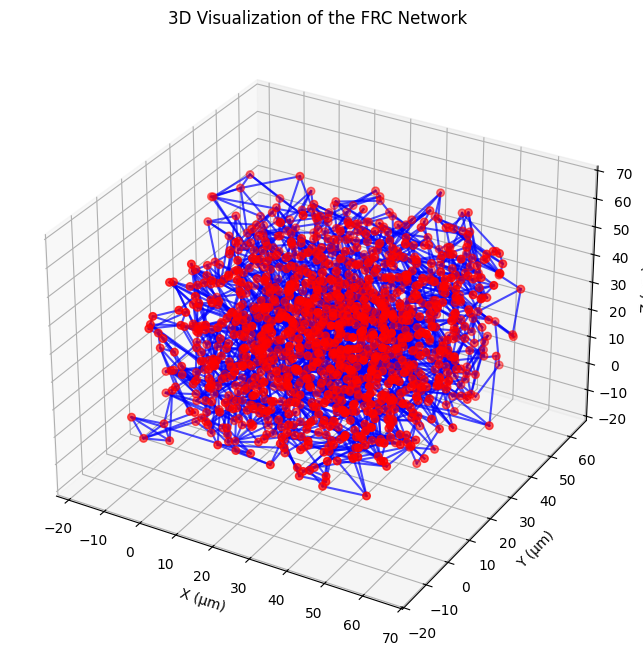

In [5]:
# 1. Function for 3D visualization of the entire network
def plot_network(positions, edges):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    # Draw edges
    for (i, j, target_length) in edges:
        p1 = positions[i]
        p2 = positions[j]
        xs, ys, zs = [p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]]
        ax.plot(xs, ys, zs, color='blue', alpha=0.7)
    # Draw all nodes
    ax.scatter(positions[:,0], positions[:,1], positions[:,2], color='red', s=30)
    ax.set_xlabel("X (μm)")
    ax.set_ylabel("Y (μm)")
    ax.set_zlabel("Z (μm)")
    ax.set_title("3D Visualization of the FRC Network")
    plt.show()
    
# Visualize the network
plot_network(positions, edges)

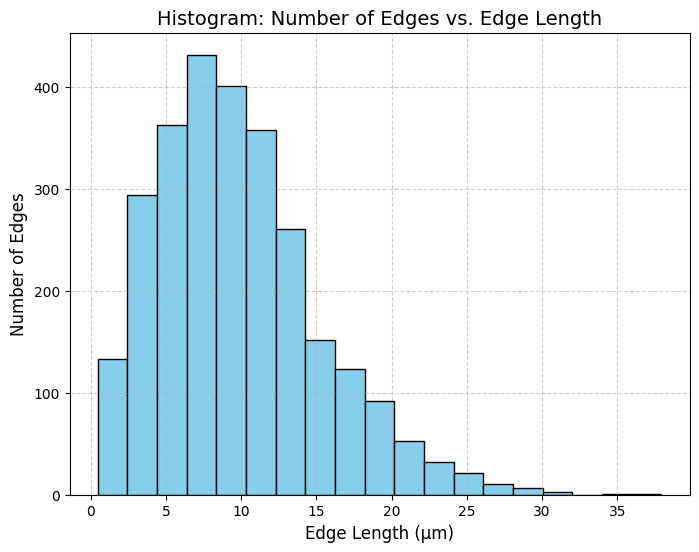

In [6]:
# To build histograms, compute:
# 2. Actual edge lengths (for each edge, calculate the distance between nodes)
actual_edge_lengths = []
for (i, j, L_target) in graph["edges"]:
    d = np.linalg.norm(graph["positions"][i] - graph["positions"][j])
    actual_edge_lengths.append(d)
actual_edge_lengths = np.array(actual_edge_lengths)

# Histogram: "Counts vs. Edge Length"
plt.figure(figsize=(8,6))
bins_edge = np.linspace(actual_edge_lengths.min(), actual_edge_lengths.max(), 20)
counts_edge, bins_edge = np.histogram(actual_edge_lengths, bins=bins_edge)
bin_centers = (bins_edge[:-1] + bins_edge[1:]) / 2
plt.bar(bin_centers, counts_edge, width=(bins_edge[1]-bins_edge[0]), color='skyblue', edgecolor='black')
plt.xlabel("Edge Length (μm)", fontsize=12)
plt.ylabel("Number of Edges", fontsize=12)
plt.title("Histogram: Number of Edges vs. Edge Length", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

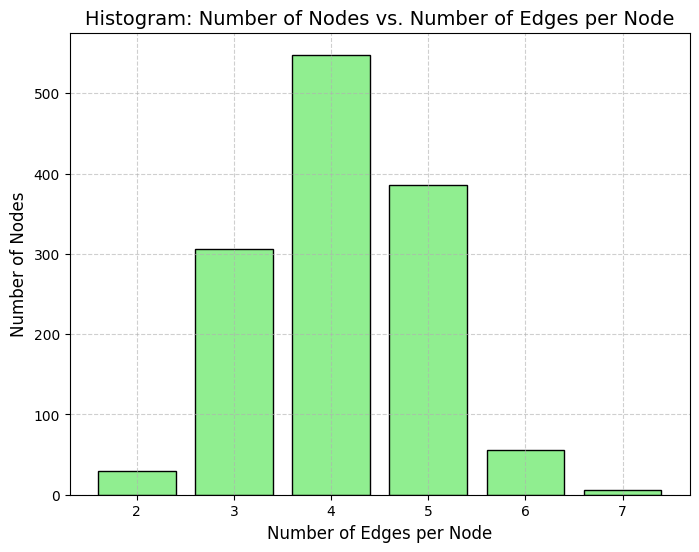

In [7]:
# 3. Actual number of edges per node
num_nodes = len(graph["target_degrees"])
actual_degrees = np.zeros(num_nodes, dtype=int)
for (i, j, _) in graph["edges"]:
    actual_degrees[i] += 1
    actual_degrees[j] += 1

# Calculate the number of nodes for each degree
degree_values, degree_counts = np.unique(actual_degrees, return_counts=True)

# Histogram: "Counts of Nodes vs. Number of Edges per Node"
plt.figure(figsize=(8,6))
plt.bar(degree_values, degree_counts, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Edges per Node", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.title("Histogram: Number of Nodes vs. Number of Edges per Node", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

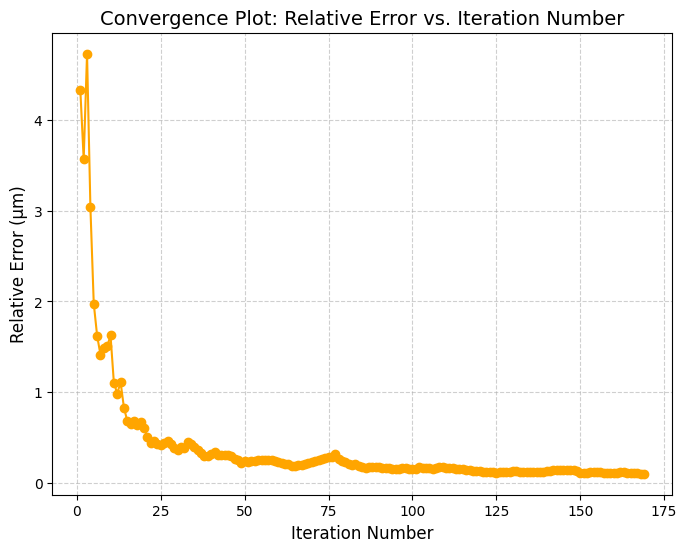

In [8]:
# 4. Distribution (histogram) of nodes by number of edges (degree)
degree_values, degree_counts = np.unique(actual_degrees, return_counts=True)

# Convergence plot: "Relative Error vs. Iteration Number"
plt.figure(figsize=(8,6))
iterations = np.arange(1, len(graph["convergence"]) + 1)
plt.plot(iterations, graph["convergence"], marker='o', linestyle='-', color='orange')
plt.xlabel("Iteration Number", fontsize=12)
plt.ylabel("Relative Error (μm)", fontsize=12)
plt.title("Convergence Plot: Relative Error vs. Iteration Number", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

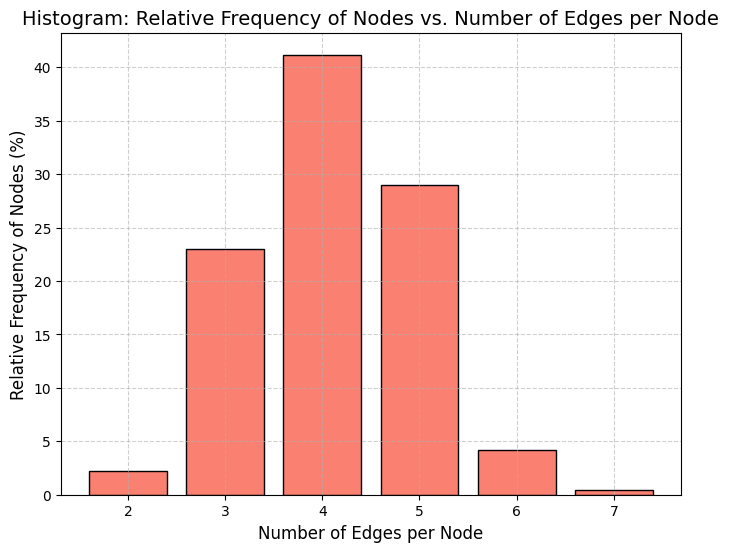

In [9]:
# 5. Relative frequencies of nodes by number of edges (in percentages)
relative_frequency = degree_counts / num_nodes * 100

# Histogram of relative frequencies of nodes vs. number of edges per node
plt.figure(figsize=(8,6))
plt.bar(degree_values, relative_frequency, color='salmon', edgecolor='black')
plt.xlabel("Number of Edges per Node", fontsize=12)
plt.ylabel("Relative Frequency of Nodes (%)", fontsize=12)
plt.title("Histogram: Relative Frequency of Nodes vs. Number of Edges per Node", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()